Métricas de comparación con los modelos entrenamos por 3 epochs

In [1]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    auc, roc_curve,
    matthews_corrcoef
)
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def get_metrics(y_test, y_test_predictions, y_probs):
    accuracy = accuracy_score(y_test, y_test_predictions)
    precision = precision_score(y_test, y_test_predictions)
    recall = recall_score(y_test, y_test_predictions)
    f1score = f1_score(y_test, y_test_predictions)
    #auc = roc_auc_score(y_test, y_test_predictions)
    mcc = matthews_corrcoef(y_test, y_test_predictions)
    conf_matrix = confusion_matrix(y_test, y_test_predictions)
    #auc_val = roc_auc_score(y_test, y_probs)
    fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label = 1)
    auc_val = auc(fpr, tpr)  

    return {"accuracy":accuracy, "precision":precision, "recall":recall, "f1score":f1score, "auc":auc_val, "mcc":mcc}




# Join all predictions

Hacemos una comparación de los modelos ESM2: t6, t12, t30 y t33; tape y protbert (entrenados con 3 epochs)

In [2]:
# junta todos los archivos de predicciones en uno solo

import pandas as pd
import numpy as np

def softmax(logits):
    return (np.exp(logits) / np.exp(logits).sum() )

data = pd.read_csv("/M2/ArgosMHC_models/dataset/hlab/hlab_test2.csv")
path_predictions = "/M2/ArgosMHC_models/predictions/" 

types_train = [
                'classic_t33_c4',       'classic_t33_c5', 
                'distilbert_t33_c3',    'distilbert_t33_c4',    'distilbert_t33_c5', 
                'lora_t33_c3',          'lora_t33_c4',          'lora_t33_c5'
               ]

for model in types_train:    
        print("loading", path_predictions + model + ".csv")
        tmp_data = pd.read_csv(path_predictions + model + ".csv", index_col=0)  
        data[model+'_prob'] = tmp_data.apply(lambda row: ( softmax([row[0], row[1]])[1] ), axis=1)
        data[model+'_pred'] = tmp_data["prediction"]  

print(data.head(5))  

loading /M2/ArgosMHC_models/predictions/classic_t33_c4.csv
loading /M2/ArgosMHC_models/predictions/classic_t33_c5.csv
loading /M2/ArgosMHC_models/predictions/distilbert_t33_c3.csv
loading /M2/ArgosMHC_models/predictions/distilbert_t33_c4.csv
loading /M2/ArgosMHC_models/predictions/distilbert_t33_c5.csv
loading /M2/ArgosMHC_models/predictions/lora_t33_c3.csv
loading /M2/ArgosMHC_models/predictions/lora_t33_c4.csv
loading /M2/ArgosMHC_models/predictions/lora_t33_c5.csv
   id          HLA   peptide  Label  Length  \
0   1  HLA-A*01:01  LFGRDLSY      1       8   
1   2  HLA-A*01:01  TDKKTHLY      1       8   
2   3  HLA-A*01:01  RSDTPLIY      1       8   
3   4  HLA-A*01:01  NSDLVQKY      1       8   
4   5  HLA-A*01:01  LSDLLDWK      1       8   

                                  mhc  classic_t33_c4_prob  \
0  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY             0.731611   
1  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY             0.459952   
2  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY             0.612253 

In [3]:
data = data.sort_values('id')
data.to_csv("all_preds.csv", index=False)

# Comparison of AUC for all combinations

In [14]:
# plot barplot for each model

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def get_auc_models(data, models):
    aucs_models = {}    

    for model in models:
        metrics = get_metrics(data['Label'], data[model+'_pred'], data[model+'_prob']) 
        aucs_models[model] = metrics["auc"]
    return aucs_models


def plot_metrics_by_type(auc_models, file_name):    

    metrics = ("Classic", "Distil", "LoRA")
    results = {
        'c3': (auc_models["classic_t33_c4"],    auc_models["distilbert_t33_c3"],    auc_models["lora_t33_c3"]),
        'c4': (auc_models["classic_t33_c4"],    auc_models["distilbert_t33_c4"],    auc_models["lora_t33_c3"]),
        'c5': (auc_models["classic_t33_c5"],    auc_models["distilbert_t33_c5"],    auc_models["lora_t33_c3"])
    }

    colors = {'c3':'#0C4483', 'c4':'#0A6AAE', 'c5':'#2C8DBE', 'ESM2(t33)':'#50B6D5', 'TAPE':'#7ECFC8', 'ProtBert':'#AADEB5'}
    #colors = {'TAPE-gas':'#0C4483', 'ESM2(t6)-fz':'#0A6AAE', 
    #          'Anthem':'#2C8DBE', 'NetMHCpan4.1':'#50B6D5', 'Acme':'#7ECFC8', 'MixMHCpred':'#AADEB5','MHCflurry':'#CDECC4'}

    x = np.arange(len(metrics))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in results.items():
        offset = width * multiplier
        rects = ax.bar(x + offset - 0.2, measurement, width, label=attribute, color=colors[attribute])
        #ax.bar_label(rects, padding=3) # agrega el valor arriba de cada barra
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('AUC')
    #ax.set_title('guin attributes by species')
    ax.set_xticks(x + width, metrics)
    ax.legend(loc='upper left', ncols=4)
    ax.set_ylim(0.4, 1.1)

    #plt.savefig("plots/" + file_name, dpi=300, bbox_inches='tight')
    plt.savefig("plots/" + file_name, format='eps', bbox_inches='tight')
    #plt.show()
    plt.clf()

data = pd.read_csv("all_preds.csv")

models = [      'classic_t33_c4',       'classic_t33_c5', 
                'distilbert_t33_c3',    'distilbert_t33_c4',    'distilbert_t33_c5', 
                'lora_t33_c3']

auc_models = get_auc_models(data, models)
plot_metrics_by_type(auc_models, "metrics_comparion.eps")
#print(auc_models)


#plot_metrics({'tape':metrics_tape, 'anthem':metrics_anthem, 'acme':metrics_acme,
#              'netmhcpan4.1':metrics_netmhcpan, 'esm2':metrics_esm2t6}, "metrics_comparison.png")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

# Getting all metrics

Obtiene todas las métricas y las guarda en un csv, esto se pondra en el paper. ES PARA EL CASO DE 3 EPCOHS

In [4]:
data = pd.read_csv("all_preds.csv")

models = [                                  'classic_t33_c4',       'classic_t33_c5', 
                'distilbert_t33_c3',        'distilbert_t33_c4',    'distilbert_t33_c5', 
                'lora_t33_c3',              'lora_t33_c3.1'
        ]
#print(data.head(5))

column_names = {
                "classic_t33_c4": "classic_c4",                 "classic_t33_c5": "classic_c5", 
                "distilbert_t33_c3": "distilbert_c3",           "distilbert_t33_c4": "distilbert_c4",       "distilbert_t33_c5": "distilbert_c5",
                "lora_t33_c3": "lora_c3",                       "lora_t33_c3.1": "lora_c3.1"
                }
def get_all_metrics():
    pd_metrics = pd.DataFrame()
    for model_name in models:
        metrics = get_metrics(data["Label"], data[model_name + "_pred"], data[model_name + "_prob"])
        pd_metrics[model_name] = list(metrics.values())
    
    
    pd_metrics = pd_metrics.rename(columns=column_names)
    pd_metrics.index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC', 'MCC']
    pd_metrics = pd_metrics.T     
    return pd_metrics

metrics_pd = get_all_metrics()
print(metrics_pd.head(24))    
metrics_pd.to_csv("metrics.csv", index=1)

               Accuracy  Precision    Recall  F1-score       AUC       MCC
classic_c4     0.690862   0.663095  0.773360  0.713995  0.747805  0.387302
classic_c5     0.749733   0.707064  0.850981  0.772376  0.821393  0.510305
distilbert_c3  0.940712   0.937015  0.944675  0.940829  0.983611  0.881454
distilbert_c4  0.933949   0.930715  0.937406  0.934048  0.980381  0.867923
distilbert_c5  0.933017   0.925990  0.940959  0.933415  0.980106  0.866150
lora_c3        0.733666   0.688069  0.852851  0.761649  0.814924  0.481533
lora_c3.1      0.758674   0.712168  0.866578  0.781822  0.841355  0.530110


Obtiene todas las métricas y las guarda en un csv, esto se pondra en el paper. ES PARA EL CASO DE 30 EPCOHS

In [7]:
data = pd.read_csv("predictions/all_preds_30epochs.csv")

models = ['esm2_t6', 'esm2_t6_freeze', 'esm2_t6_acc_steps', 'esm2_t6_freeze_acc_steps',          
          'esm2_t30', 'esm2_t30_freeze', 'esm2_t30_acc_steps', 'esm2_t30_freeze_acc_steps',          
          'tape', 'tape_freeze', 'tape_acc_steps', 'tape_freeze_acc_steps']
#print(data.head(5))

column_names = {"esm2_t6": "ESM2(t6)", "esm2_t6_freeze": "ESM2(t6)-Freeze", "esm2_t6_acc_steps": "ESM2(t6)-GAS", "esm2_t6_freeze_acc_steps": "ESM2(t6)-Freeze-GAS",                
                "esm2_t30": "ESM2(t30)", "esm2_t30_freeze": "ESM2(t30)-Freeze", "esm2_t30_acc_steps": "ESM2(t30)-GAS", "esm2_t30_freeze_acc_steps": "ESM2(t30)-Freeze-GAS",                
                "tape": "TAPE", "tape_freeze": "TAPE-Freeze", "tape_acc_steps": "TAPE-GAS", "tape_freeze_acc_steps": "TAPE-Freeze-GAS"}
def get_all_metrics():
    pd_metrics = pd.DataFrame()
    for model_name in models:
        metrics = get_metrics(data["Label"], data[model_name + "_pred"], data[model_name + "_prob"])
        pd_metrics[model_name] = list(metrics.values())
    
    
    pd_metrics = pd_metrics.rename(columns=column_names)
    pd_metrics.index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC', 'MCC']
    pd_metrics = pd_metrics.T     
    return pd_metrics

metrics_pd = get_all_metrics()
print(metrics_pd.head(24))    
metrics_pd.to_csv("metrics_30_epochs.csv", index=1)

                      Accuracy  Precision    Recall  F1-score       AUC  \
ESM2(t6)              0.938967   0.933250  0.945291  0.939232  0.979740   
ESM2(t6)-Freeze       0.940109   0.939831  0.940158  0.939994  0.983045   
ESM2(t6)-GAS          0.936580   0.932236  0.941319  0.936756  0.981802   
ESM2(t6)-Freeze-GAS   0.935392   0.932595  0.938335  0.935456  0.981257   
ESM2(t30)             0.498957   0.498957  1.000000  0.665739  0.499899   
ESM2(t30)-Freeze      0.939251   0.930368  0.949297  0.939737  0.978682   
ESM2(t30)-GAS         0.934569   0.933728  0.935246  0.934486  0.980837   
ESM2(t30)-Freeze-GAS  0.936290   0.931909  0.941075  0.936470  0.981760   
TAPE                  0.498957   0.498957  1.000000  0.665739  0.511077   
TAPE-Freeze           0.939518   0.940425  0.938219  0.939320  0.981509   
TAPE-GAS              0.941482   0.935239  0.948392  0.941769  0.984124   
TAPE-Freeze-GAS       0.935908   0.929711  0.942829  0.936224  0.981968   

                        

# AUC por k-mer y HLA

Obtiene el AUC por k-mer y por HLA. Todo se guarda en un diccionario

In [49]:
data = pd.read_csv("predictions/all_preds.csv")

def get_auc(data_by_kmer, models):
    hlas = data_by_kmer['HLA'].unique()

    aucs_models = {}
    for model in models:
        aucs_models[model] = []
            
    for hla in hlas:
        data_by_kmer_hla = data_by_kmer[data_by_kmer['HLA'] == hla]
        
        #metrics = get_metrics(data_by_kmer_hla['Label'], data_by_kmer_hla['esm2_t6_pred'], data_by_kmer_hla['esm2_t6_prob']) 
        #aucs.append(metrics["auc"])
        for model in models:
            metrics = get_metrics(data_by_kmer_hla['Label'], data_by_kmer_hla[model+'_pred'], data_by_kmer_hla[model+'_prob']) 
            aucs_models[model].append(metrics["auc"])

    #print(aucs_models)
    return aucs_models

# k-mer
models = ['esm2_t6', 'esm2_t6_freeze', 'esm2_t6_acc_steps', 'esm2_t6_freeze_acc_steps',
          'esm2_t12', 'esm2_t12_freeze', 'esm2_t12_acc_steps', 'esm2_t12_freeze_acc_steps',
          'esm2_t30', 'esm2_t30_freeze', 'esm2_t30_acc_steps', 'esm2_t30_freeze_acc_steps',
          'esm2_t33', 'esm2_t33_freeze', 'esm2_t33_acc_steps', 'esm2_t33_freeze_acc_steps',
          'tape', 'tape_freeze', 'tape_acc_steps', 'tape_freeze_acc_steps',
          'protbert', 'protbert_freeze', 'protbert_acc_steps', 'protbert_freeze_acc_steps']
total_aucs = {}
for i in range(8,15):
    data_by_kmer = data[data['Length'] == i] 
    total_aucs[i] = get_auc(data_by_kmer, models)



In [83]:
for k in range(8,15):
    # plotting
    aucs_models = total_aucs[k]
    datat6 = [ aucs_models['esm2_t6'], aucs_models['esm2_t6_freeze'], aucs_models['esm2_t6_acc_steps'],aucs_models['esm2_t6_freeze_acc_steps']]
    datat12 = [ aucs_models['esm2_t12'], aucs_models['esm2_t12_freeze'], aucs_models['esm2_t12_acc_steps'],aucs_models['esm2_t12_freeze_acc_steps']]
    datat30 = [ aucs_models['esm2_t30_freeze'], aucs_models['esm2_t30_acc_steps'],aucs_models['esm2_t12_freeze_acc_steps']]
    datat33 = [ aucs_models['esm2_t33_freeze'], aucs_models['esm2_t33_acc_steps'],aucs_models['esm2_t33_freeze_acc_steps']]
       
    #labels = ['Normal', 'Freeze', 'GAS', 'Freeze-GAS']
    labels = ['', '', '', '']
    palette = ['lightgreen', '#3470E0', 'y', '#3DCACE']
    bp = plt.boxplot(datat6, labels=labels, positions=[1, 2, 3, 4], showfliers = False, patch_artist=True)
    for i, box in enumerate(bp['boxes']):
        box.set(color="black")
        box.set(facecolor = palette[i] )

    bp = plt.boxplot(datat12, labels=labels, positions=[6, 7, 8, 9], showfliers = False, patch_artist=True)
    for i, box in enumerate(bp['boxes']):
        box.set(color="black")
        box.set(facecolor = palette[i] )

    bp = plt.boxplot(datat30, labels=labels[1:len(labels)], positions=[11, 12, 13], showfliers = False, patch_artist=True)
    for i, box in enumerate(bp['boxes']):
        box.set(color="black")
        box.set(facecolor = palette[i+1] )

    bp = plt.boxplot(datat33, labels=labels[1:len(labels)], positions=[15, 16, 17], showfliers = False, patch_artist=True)
    for i, box in enumerate(bp['boxes']):
        box.set(color="black")
        box.set(facecolor = palette[i+1] )

    #plt.show()
    #plt.clf()
    plt.savefig("plots/auc_distribution_esm2t6_" + str(k) + "-mer", dpi=300, bbox_inches='tight')
    plt.clf()

<Figure size 640x480 with 0 Axes>

# Training metrics

# Gradients

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


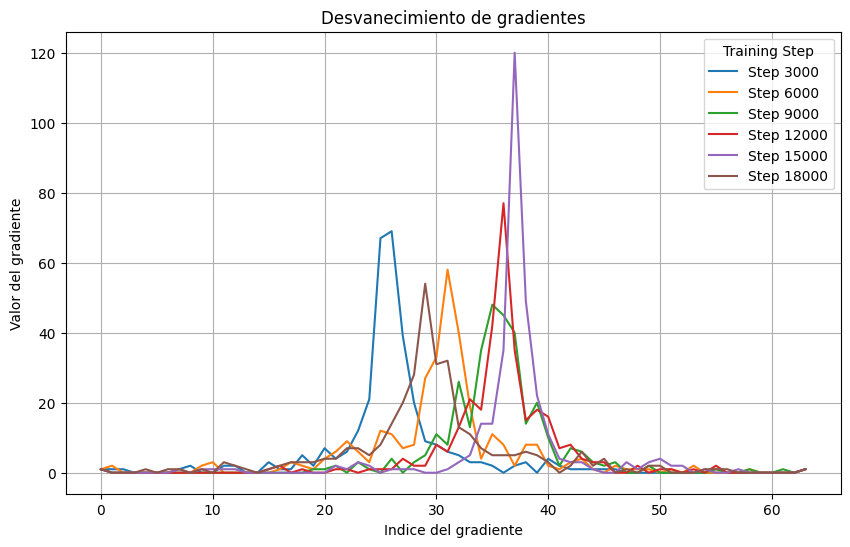

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Cargar el archivo CSV
file_path = 'plots/esm2_t6_c1_gradients_layer1.csv'  # Cambia esto si es necesario
gradient_data = pd.read_csv(file_path)

# Extraer los valores de gradientes de cada paso y convertirlos a listas de números
gradient_column = 'esm_t6_c1 - gradients/bert.encoder.layer.1.attention.self.key.bias'

# Parsear los valores que están en formato JSON
gradient_values = gradient_data[gradient_column].apply(lambda x: json.loads(x).get("values", []) if isinstance(x, str) else [])

# Configurar el gráfico de gradientes
plt.figure(figsize=(10, 6))

# Extraer los valores de los pasos de entrenamiento
global_steps = gradient_data['train/global_step'].values
gradient_values_list = gradient_values.tolist()

# Dibujar los gradientes para cada paso
for i, gradient in enumerate(gradient_values_list):
    sns.lineplot(x=np.arange(len(gradient)), y=gradient, label=f'Step {global_steps[i]}')

# Configurar etiquetas y título
plt.title('Desvanecimiento de gradientes')
plt.xlabel('Indice del gradiente')
plt.ylabel('Valor del gradiente')
plt.legend(title='Training Step')
plt.grid(True)

#Guardar el grafico
plt.savefig('plots/gradiente.eps', format='eps')